In [1]:
import models
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def write_transition_matrix(state_space, lambda_, mu_):
    lenS = len(state_space)
    m = np.zeros((lenS, lenS))
    for i in range(lenS - 1):
        m[(i, i + 1)] = lambda_
        m[(i + 1, i)] = mu_
    m = m - np.multiply(np.identity(lenS), m.sum(axis=1))
    return m

In [3]:
def plot(probs, hitting=False, maxy=None):
    fig, ax = plt.subplots(1, figsize=(12, 4))
    ax.bar(probs.keys(), probs.values(), color="lightgrey", edgecolor="black")
    ax.set_xlabel("State", fontsize=14)
    state_space = probs.keys()
    if hitting:
        ax.set_ylabel(f"Hitting Probability to state {max(state_space)}", fontsize=14)
        reasonable = max(state_space) * 0.75
        epsilon = 0.05
        ep_loc = max(state_space) * 0.02
        away_from = max(state_space) * 0.02
        ax.axvline(x=reasonable, c="black", linestyle="dashed")
        ax.axhline(y=epsilon, c="black", linestyle="dashed")
        ax.text(ep_loc, epsilon + 0.02, f"$\epsilon = {epsilon}$", fontsize=14)
        ax.text(
            reasonable - away_from,
            1.05,
            r"$\longleftarrow$ Reasonable Region",
            fontsize=14,
            ha="right",
        )
        ax.text(
            reasonable + away_from,
            1.05,
            r"Unreasonable Region $\longrightarrow$",
            fontsize=14,
            ha="left",
        )
        ax.set_ylim(top=1.15)
    else:
        epsilon = 0.02
        ep_loc = max(state_space) * 0.92
        ax.axhline(y=epsilon, c="black", linestyle="dashed")
        ax.text(ep_loc, epsilon + 0.01, f"$\epsilon = {epsilon}$", fontsize=14)
        ax.set_ylabel("Steady-State Probability", fontsize=14)
        if maxy is not None:
            ax.set_ylim(top=maxy)
    return fig

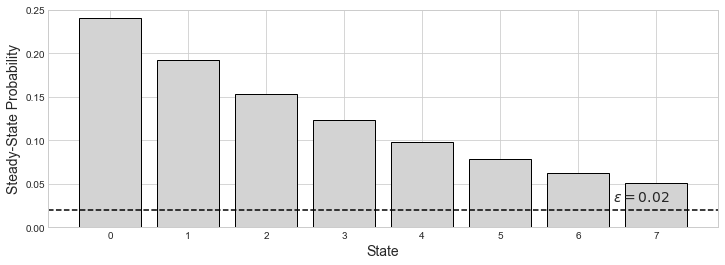

In [4]:
state_space = range(8)
transition_matrix = write_transition_matrix(state_space, 4, 5)
probs = models.solve_probabilities(state_space, transition_matrix)
fig = plot(probs, maxy=0.25)
plt.savefig("../tex/img/example_mc_8states.pdf")

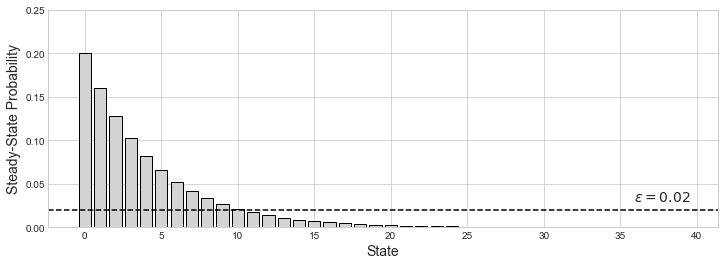

In [5]:
state_space = range(40)
transition_matrix = write_transition_matrix(state_space, 4, 5)
probs = models.solve_probabilities(state_space, transition_matrix)
fig = plot(probs, maxy=0.25)
plt.savefig("../tex/img/example_mc_40states.pdf")

In [6]:
def write_transition_matrix_absorbing(state_space, lambda_, mu_):
    lenS = len(state_space)
    m = np.zeros((lenS, lenS))
    for i in range(lenS - 1):
        m[(i, i + 1)] = lambda_
        m[(i + 1, i)] = mu_
    m[(0, 1)] = 0
    m = m - np.multiply(np.identity(lenS), m.sum(axis=1))
    return m

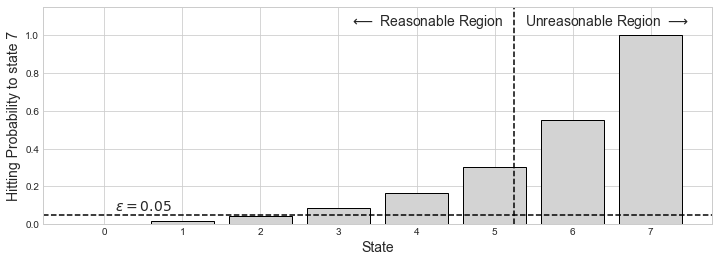

In [7]:
state_space = range(8)
transition_matrix = write_transition_matrix_absorbing(state_space, 4, 5)
hitting_probs = models.find_hitting_probs(state_space, transition_matrix, [7])
fig = plot(hitting_probs, hitting=True)
plt.savefig("../tex/img/example_absorbingmc_8states.pdf")

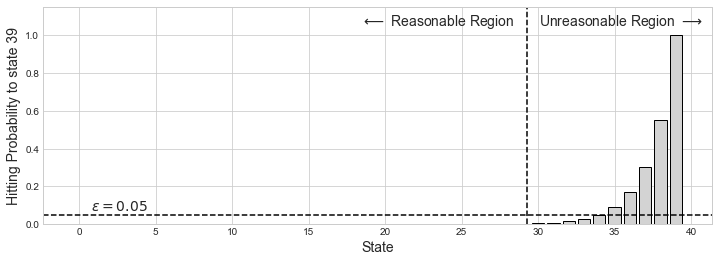

In [8]:
state_space = range(40)
transition_matrix = write_transition_matrix_absorbing(state_space, 4, 5)
hitting_probs = models.find_hitting_probs(state_space, transition_matrix, [39])
fig = plot(hitting_probs, hitting=True)
plt.savefig("../tex/img/example_absorbingmc_40states.pdf")

# Investigate what happens when we increase the boundary

In [9]:
def check(hitting_probs, reasonable_ratio, epsilon):
    """
    Checks whether the hitting probabilities satisfy the check:
    that no state in the reasonable region has probability of
    hitting the boundary greater than epsilon.
    """
    state_space = hitting_probs.keys()
    reasonable = math.ceil(max(state_space) * reasonable_ratio)
    for state in range(reasonable):
        if hitting_probs[state] > epsilon:
            return False
    return True

In [10]:
def solve_time_to_absorbtion(State_Space, transition_matrix):
    """
    Finds the mean time to absorbtion for transition matrix.
    """
    size_mat = len(State_Space)
    T = transition_matrix[1:, 1:]
    b = np.ones(size_mat - 1)
    time2absorb = np.linalg.solve(-T, b)
    mean_sojourn_time = {State_Space[i]: float(t) for i, t in enumerate(time2absorb)}
    return mean_sojourn_time

In [11]:
def plot_absorbtion_time_vs_check(epsilon, R, ax):
    checks = []
    time_to_absorbtions = []
    limits = range(8, 70)
    for limit in limits:
        state_space = range(limit)
        transition_matrix = write_transition_matrix_absorbing(state_space, 4, 5)
        hitting_probs = models.find_hitting_probs(
            state_space, transition_matrix, [limit - 1]
        )
        c = check(hitting_probs, R, epsilon)
        a = solve_time_to_absorbtion(state_space, transition_matrix)
        checks.append(c)
        time_to_absorbtions.append(a[6])
    limits_passed = [
        limit for limit, check_passed in zip(limits, checks) if check_passed
    ]
    times_passed = [
        time for time, check_passed in zip(time_to_absorbtions, checks) if check_passed
    ]
    limits_failed = [
        limit for limit, check_passed in zip(limits, checks) if not check_passed
    ]
    times_failed = [
        time
        for time, check_passed in zip(time_to_absorbtions, checks)
        if not check_passed
    ]
    ax.plot(limits_passed, times_passed, c="green", linewidth=2, label="Passed Check")
    ax.plot(
        limits_failed,
        times_failed,
        c="red",
        linewidth=2,
        linestyle="dotted",
        label="Failed Check",
    )
    ax.set_xlabel("Boundary")
    ax.set_ylabel("Time to Absorption")
    ax.set_title(f"$\epsilon = {epsilon}$, $r = {R}$")

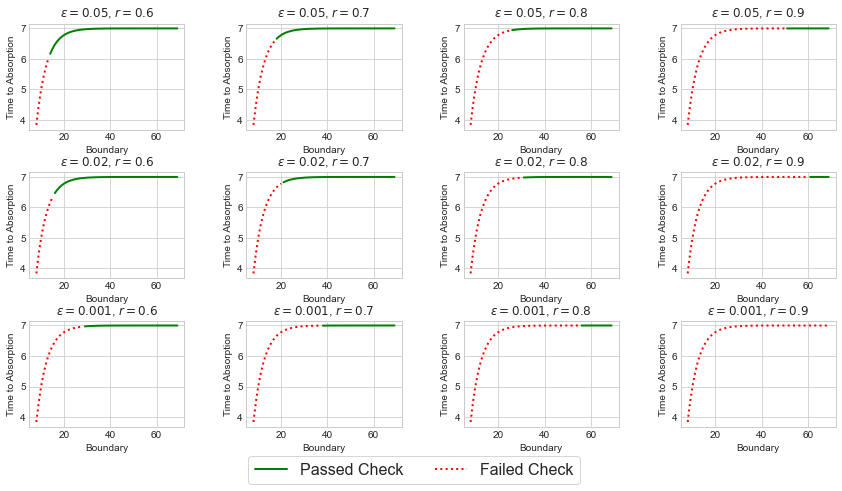

In [12]:
fig, axarr = plt.subplots(3, 4, figsize=(14, 8))
plot_absorbtion_time_vs_check(0.05, 0.6, axarr[0, 0])
plot_absorbtion_time_vs_check(0.05, 0.7, axarr[0, 1])
plot_absorbtion_time_vs_check(0.05, 0.8, axarr[0, 2])
plot_absorbtion_time_vs_check(0.05, 0.9, axarr[0, 3])
plot_absorbtion_time_vs_check(0.02, 0.6, axarr[1, 0])
plot_absorbtion_time_vs_check(0.02, 0.7, axarr[1, 1])
plot_absorbtion_time_vs_check(0.02, 0.8, axarr[1, 2])
plot_absorbtion_time_vs_check(0.02, 0.9, axarr[1, 3])
plot_absorbtion_time_vs_check(0.001, 0.6, axarr[2, 0])
plot_absorbtion_time_vs_check(0.001, 0.7, axarr[2, 1])
plot_absorbtion_time_vs_check(0.001, 0.8, axarr[2, 2])
plot_absorbtion_time_vs_check(0.001, 0.9, axarr[2, 3])
axarr[0, 0].legend(fontsize=16, ncol=2, frameon=True, bbox_to_anchor=(3.6, -3))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.savefig("../tex/img/check_hyperparameters_effect.pdf")

In [13]:
def get_error_and_bound(epsilon, R, true_value):
    limits = range(8, 100)
    for limit in limits:
        state_space = range(limit)
        transition_matrix = write_transition_matrix_absorbing(state_space, 4, 5)
        hitting_probs = models.find_hitting_probs(
            state_space, transition_matrix, [limit - 1]
        )
        c = check(hitting_probs, R, epsilon)
        a = solve_time_to_absorbtion(state_space, transition_matrix)
        if c:
            return abs(a[6] - true_value), limit
    return np.nan, np.nan

In [14]:
state_space = range(200)
transition_matrix = write_transition_matrix_absorbing(state_space, 4, 5)
a = solve_time_to_absorbtion(state_space, transition_matrix)
true_value = a[6]

In [15]:
Rs = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
epsilons = np.arange(0.001, 0.051, 0.001)

In [16]:
errors = {}
bounds = {}
for R in Rs:
    errors[R] = []
    bounds[R] = []
    for epsilon in epsilons:
        e, b = get_error_and_bound(epsilon, R, true_value)
        errors[R].append(e)
        bounds[R].append(b)

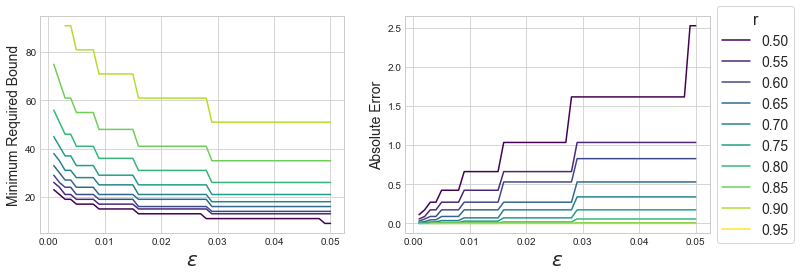

In [17]:
fig, axarr = plt.subplots(1, 2, figsize=(12, 4))
vals = np.linspace(0, 1, len(Rs))
for R, v in zip(Rs, vals):
    col = plt.cm.viridis(v)
    axarr[1].plot(epsilons, errors[R], color=col, label=format(R, ".2f"))
    axarr[0].plot(epsilons, bounds[R], color=col, label=format(R, ".2f"))
axarr[1].legend(
    fontsize=14,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    ncol=1,
    frameon=True,
    title="r",
    title_fontsize=16,
)
axarr[1].set_xlabel(r"$\epsilon$", fontsize=20)
axarr[0].set_xlabel(r"$\epsilon$", fontsize=20)
axarr[1].set_ylabel("Absolute Error", fontsize=14)
axarr[0].set_ylabel("Minimum Required Bound", fontsize=14)
fig.savefig("../tex/img/check_hyperparameters_effect_summary.pdf")